In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir='/content/drive/MyDrive/CVPR-Final/dataset'
import os

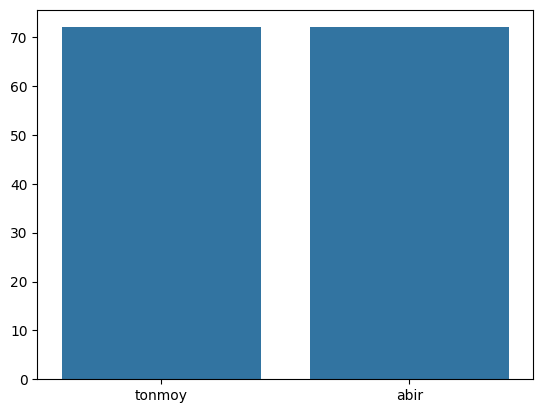

In [6]:
IMG_SIZE=128
BATCH_SIZE=16
categories = []
class_count = []

train_example = 0
for f in os.listdir(data_dir):
    files = gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][eE][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[pP][nN][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[hH][eE][iI][cC]'))

    categories.append(f)
    class_count.append(len(files))
    train_example += len(files)

sns.barplot(x=categories, y=class_count)
plt.show()

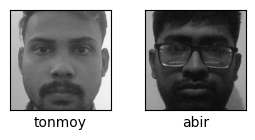

In [7]:
plt.figure(figsize=(15,4))
i=0
for c in categories:
    path = os.path.join(data_dir,c)
    try:
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            plt.subplot(3,11,i+1)
            plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
            plt.xlabel(c)
            plt.xticks([])
            plt.yticks([])
            i += 1
            break
    except Exception as e:
        pass
plt.tight_layout()
plt.show()

In [8]:
train_gen = ImageDataGenerator(
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=30,
     # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.2,
    # set range for random zoom
    zoom_range=0.3,
    # randomly flip images
    horizontal_flip=True,
    # set function that will be applied on each input
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
train_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)
valid_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 116 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


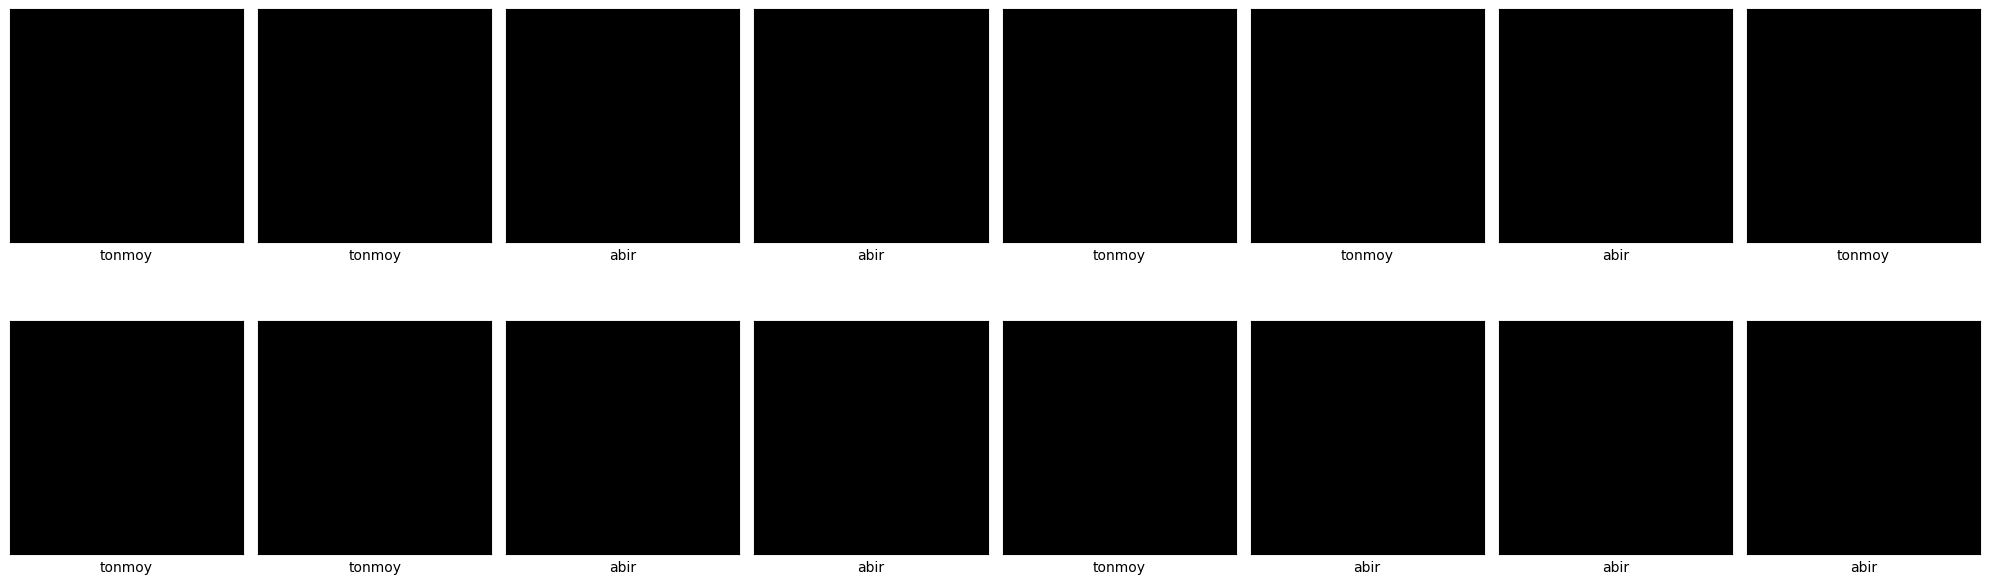

In [9]:
# display 16 items  for a batch
imgs, labels = next(train_batches)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(2,8,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(categories[label.astype('int32')])
    i+=1
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [10]:
imput_shape = (IMG_SIZE, IMG_SIZE)+(3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=imput_shape,
    include_top=False,
    weights='imagenet'
)
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = base_model(input,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(categories),activation='softmax')(x)
model = tf.keras.Model(input,output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,078,338 (11.74 MB)

 Trainable params: 3,044,226 (11.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [13]:
h = model.fit(
    train_batches,steps_per_epoch=344//BATCH_SIZE,
    epochs=30,
    validation_data=valid_batches,
    validation_steps=72//BATCH_SIZE,
   # callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 8/21 ━━━━━━━━━━━━━━━━━━━━ 1:41 8s/step - accuracy: 0.7307 - loss: 0.5686

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


21/21 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.7960 - loss: 0.5093 - val_accuracy: 0.5000 - val_loss: 0.6990
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 314ms/step - accuracy: 0.9708 - loss: 0.2155 - val_accuracy: 0.5714 - val_loss: 0.6478
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.9938 - loss: 0.0763 - val_accuracy: 0.5000 - val_loss: 0.9040
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 1.0000 - loss: 0.0242 - val_accuracy: 0.5000 - val_loss: 1.6832
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 379ms/step - accuracy: 0.9869 - loss: 0.0531 - val_accuracy: 0.5357 - val_loss: 1.8705
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.5714 - val_loss: 1.2519
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.7143 - val_loss: 0.8551
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.5357 - val_

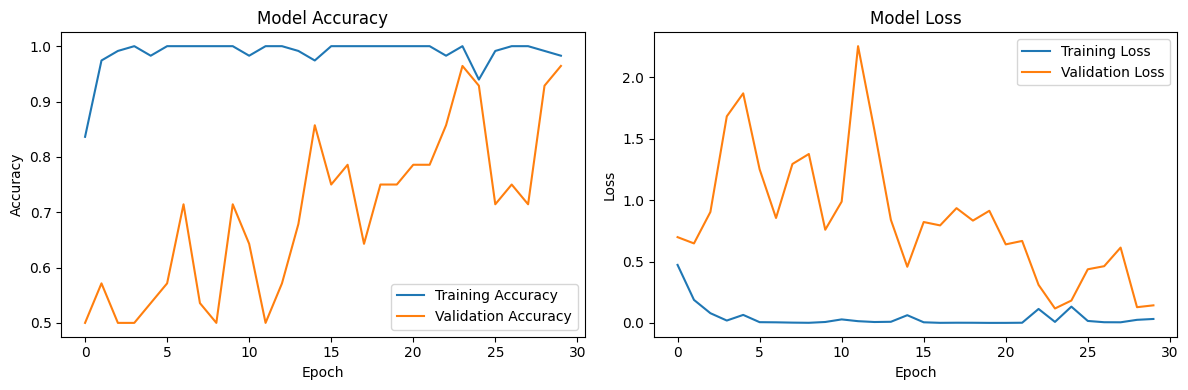

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()